# Confront the NPZ model with real data from Narragansett Bay

## 1. A first look at the data

In [1]:
%matplotlib notebook
import numpy as np

# load data from CSV file
datafile = 'data/data_npz_narragansett.csv'
data = np.loadtxt(datafile, skiprows=1, delimiter=',')
with open(datafile) as f:
    data_names = f.readline().strip().split(',')
print(data_names)

['time (days)', 'NO3 (mg N/m3)', 'P (mg N/m3)', 'Z (mg N/m3)']


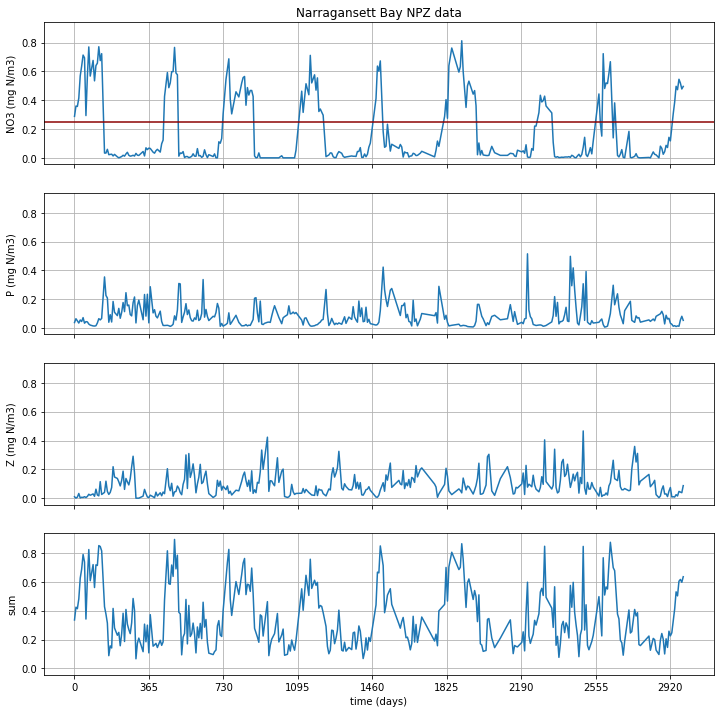

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=4, sharex=True, sharey=True, figsize=(12,12))
for iax,ax in enumerate(axs.flat[:-1]):
    ax.plot(data[:,0], data[:,iax+1])
    ax.set_ylabel(data_names[iax+1])
    ax.grid(True)
axs[0].set_title('Narragansett Bay NPZ data')
axs[0].axhline(0.25, color='darkred')
axs[-1].plot(data[:,0],  np.sum(data[:,1:],axis=1))
axs[-1].set(xlabel=data_names[0], ylabel='sum', xticks=np.arange(0.0,data[-1,0],365.0))
axs[-1].grid(True)

### challenges for fitting data:
 * high noise level
 * no conservation of mass while NPZ model conserves mass

## 2. Modifications to the NPZ model

allow influx and loss of N in the model:
 * introduce a background concentration for each variable and allow mixing with that background concentration
 * have a winter period for each year with stronger mixing and different background concentrations
 * estimate start and duration of winter period for each year (initial guess is based on data)
 * estimate background concentrations for winter and regular period (same for each year)
 
 

In [3]:
# base initial guess of start and duration of the winter period based on N crossing a 0.25 threshold

stan_code_dataparams = '''data {
    int<lower=0> nobs;               // number of timesteps with observations
    real<lower=0> tobs[nobs];        // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=1, P=2, Z=3)
    real<lower=0> obs[nobs,nobsvar]; // observed variable at measurement times
    int<lower=0> nyears;             // number of years (number of winters to add to the model)
}
transformed data {
    real wintermixstart_guess[nyears];
    real wintermixduration_guess[nyears];
    {
        int start = 0;
        int iyear = 1;
        real thresh = 0.25;
        for (it in 1:nobs){
            if (start == 0 && obs[it,1] >= thresh){
                start = 1;
                wintermixstart_guess[iyear] = tobs[it];
            } else if (start == 1 && obs[it,1] < thresh && obs[it+1,1] < thresh){
                start = 0;
                wintermixduration_guess[iyear] = tobs[it] - wintermixstart_guess[iyear];
                wintermixstart_guess[iyear] -= 365.0*(iyear-1);
                iyear += 1;
                if (iyear > nyears){
                    break;
                }
            }
        }
    }
    // will be printed once by every chain
    print("wintermixstart_guess = ",wintermixstart_guess);
    print("wintermixduration_guess = ",wintermixduration_guess);
}
parameters {
    real<lower=0> vmax;        // maximum growth rate in Michaelis Menten formulation
    real<lower=0> nuthalfsat;  // nutrient half saturation in Michaelis Menten formulation
    real<lower=0> graz;        // zooplankton grazing rate
    real<lower=0> mort_p;      // phytoplankton mortality rate
    real<lower=0> mort_z;      // zooplankton mortality rate
    real<lower=0> bgconc_n1;   // N background concentration regular
    real<lower=0> bgconc_n2;   // N background concentration winter
    real<lower=0> bgconc_p1;   // P background concentration regular
    real<lower=0> bgconc_p2;   // P background concentration winter
    real<lower=0> bgconc_z1;   // Z background concentration regular
    real<lower=0> bgconc_z2;   // Z background concentration winter
    real<lower=0> mix1;        // mixing strength regular
    real<lower=0> mix2;        // mixing strength winter
    real<lower=-100.0,upper=200.0> wintermixstart[nyears]; // start of winter mixing, restricted to broad winter period
    real<lower=0> wintermixduration[nyears]; // duration of winter mixing

    real<lower=1E-15> sigma[nobsvar]; // observation error standard deviations
    real<lower=0> x0[3];              // initial conditions
}
transformed parameters {
    real theta[13+2*nyears];
    real x[nobs,3];

    theta[1] = vmax;
    theta[2] = nuthalfsat;
    theta[3] = graz;
    theta[4] = mort_p;
    theta[5] = mort_z;
    theta[6] = bgconc_n1;
    theta[7] = bgconc_n2;
    theta[8] = bgconc_p1;
    theta[9] = bgconc_p2;
    theta[10] = bgconc_z1;
    theta[11] = bgconc_z2;
    theta[12] = mix1;
    theta[13] = mix2;
    for (iyear in 1:nyears){
        theta[13+2*iyear-1] = wintermixstart[iyear] + (iyear-1)*365.0;
        theta[13+2*iyear] = theta[13+2*iyear-1] + wintermixduration[iyear];
    }
    x = integrate_ode_rk45(npz, x0, -1, tobs, theta,
                           rep_array(0.0, 0), rep_array(0, 0),
                           1e-5, 1e-4, 2e3*nyears);
}
'''

In [4]:
# for now, do not fit data

stan_code_model_nofit = '''model {

    x0[1] ~ normal(0.3, 0.1);         // prior on N initial conditions
    x0[2] ~ normal(0.1, 0.1);         // prior on P initial conditions
    x0[3] ~ normal(0.1, 0.1);         // prior on Z initial conditions

    sigma      ~ exponential(1.0);

    // priors for parameters
    vmax       ~ normal(0.15, 0.03);
    nuthalfsat ~ normal(0.17, 0.04);
    graz       ~ normal(0.15, 0.04);
    mort_p     ~ normal(0.02, 0.01);
    mort_z     ~ normal(0.02, 0.005);
    bgconc_n1  ~ normal(0.01, 0.001); // (regular) 
    bgconc_n2  ~ normal(0.66, 0.08);  // (winter) 
    bgconc_p1  ~ normal(0.11, 0.01);  // (regular)
    bgconc_p2  ~ normal(0.05, 0.005); // (winter)
    bgconc_z1  ~ normal(0.09, 0.01);  // (regular)
    bgconc_z2  ~ normal(0.05, 0.03);  // (winter)
    mix1       ~ normal(0.01, 0.03);  // (regular)
    mix2       ~ normal(0.19, 0.02);  // (winter)
    for (iyear in 1:nyears){
        wintermixstart[iyear]    ~ normal(wintermixstart_guess[iyear], 10.0);
        wintermixduration[iyear] ~ normal(wintermixduration_guess[iyear], 10.0);
    }
    // no fitting of data yet
}
'''

In [5]:
# mixing/exchange with background concentrations is implemented using a nudging/relaxation term

stan_code_functions = '''functions {
    real[] npz(real   t,     // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // real-valued input data (empty)
              int[]  x_i) { // integer-valued input data (empty)
    /*
    guide to theta:
    theta[1]:  vmax        maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat  nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz        zooplankton grazing rate
    theta[4]:  mort_p      phytoplankton mortality rate
    theta[5]:  mort_z      zooplankton mortality rate
    theta[6]:  bgconc_n1   N background concentration regular
    theta[7]:  bgconc_n2   N background concentration winter
    theta[8]:  bgconc_p1   P background concentration regular
    theta[9]:  bgconc_p2   P background concentration winter
    theta[10]: bgconc_z1   Z background concentration regular
    theta[11]: bgconc_z2   Z background concentration winter
    theta[12]: mix1        mixing strength regular
    theta[13]: mix2        mixing strength winter
    theta[14]:             start time of first winter
    theta[15]:             stop time of first winter
    theta[16]:             start time of second winter
    theta[17]:             stop time of second winter
    ...                    number of winters is set to nyears
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real growth  = theta[1]*n/(theta[2]+n) * p; // nutrient-dependent growth
    real grazing = theta[3]*p*z;                // grazing
    real ploss   = theta[4]*p;                  // linear phytoplankton mortality
    real zloss   = theta[5]*z*z;                // quadratic zooplankton mortality

    // N,P,Z gain or loss terms due to mixing/exchange with background
    real exch_n;
    real exch_p;
    real exch_z;

    int i = 14;
    while (i <= size(theta) && t>=theta[i]){
        i += 1;
    }
    if ((i-13)%2 == 1){
        // regular (non-winter) time
        exch_n = theta[12]*(theta[6]-n);
        exch_p = theta[12]*(theta[8]-p);
        exch_z = theta[12]*(theta[10]-z);
    } else {
        // winter time
        exch_n = theta[13]*(theta[7]-n);
        exch_p = theta[13]*(theta[9]-p);
        exch_z = theta[13]*(theta[11]-z);
    }
    return {-growth+ploss+zloss+exch_n,growth-grazing-ploss+exch_p,grazing-zloss+exch_z};
    }
}
'''

## 3. Sampling from the prior

Because we are not yet fitting data in the model, the Stan output are samples from the prior model solution.

In [6]:
import pystan

# stitch together the code and compile it
stan_code = stan_code_functions + stan_code_dataparams + stan_code_model_nofit
model = pystan.StanModel(model_code=stan_code, model_name='NPZ')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL NPZ_f4f4c4bf230ac59beb050edb0361f6f3 NOW.


In [7]:
# reduce the dataset (to decrease runtime)
nyears = 2
index = data[:,0] <= nyears * 365

stan_data = {
    'nobs':sum(index), 
    'tobs':data[index,0],
    'nobsvar':3,
    'iobsvar':(1,2,3), # all variables are observed 
    'obs':data[index,1:],
    'nyears':nyears,
}

In [8]:
# run the model, note low number of iterations/length of chain
mcmc = model.sampling(data=stan_data, iter=1000)
print(mcmc)

Inference for Stan model: NPZ_f4f4c4bf230ac59beb050edb0361f6f3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
vmax                   0.15  5.9e-4   0.03   0.09   0.13   0.15   0.17   0.21   2603    1.0
nuthalfsat             0.17  7.4e-4   0.04    0.1   0.14   0.17    0.2   0.25   2857    1.0
graz                   0.15  8.4e-4   0.04   0.07   0.13   0.15   0.17   0.23   2255    1.0
mort_p                 0.02  2.5e-4 9.5e-3 2.7e-3   0.01   0.02   0.03   0.04   1495    1.0
mort_z                 0.02  9.9e-5 5.0e-3   0.01   0.02   0.02   0.02   0.03   2531    1.0
bgconc_n1              0.01  1.9e-5 1.0e-3 8.0e-3 9.3e-3   0.01   0.01   0.01   2761    1.0
bgconc_n2              0.66  1.3e-3   0.08    0.5   0.61   0.66   0.71   0.81   3555    1.0
bgconc_p1              0.11  1.9e-4   0.01   0.09    0.1   0.11   0.12   0.13   2910

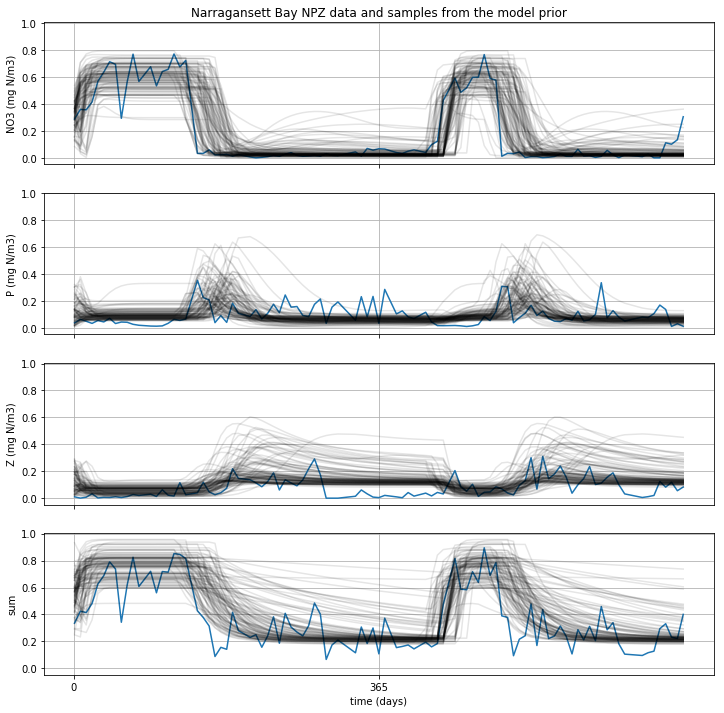

In [9]:
# plot 100 randomly chosen prior solutions
index_prior = np.random.choice(mcmc['x'].shape[0], 100, replace=False)

t = data[index,0]

fig, axs = plt.subplots(nrows=4, sharex=True, sharey=True, figsize=(12,12))
for iax,ax in enumerate(axs.flat[:-1]):
    ax.plot(t, data[index,iax+1])
    ax.plot(t, mcmc['x'][index_prior,:,iax].T, color='k', alpha=0.1)
    ax.set_ylabel(data_names[iax+1])
    ax.grid(True)
axs[0].set_title('Narragansett Bay NPZ data and samples from the model prior')
axs[-1].plot(t, np.sum(data[index,1:],axis=1))
axs[-1].plot(t, np.sum(mcmc['x'][index_prior,:,:],axis=2).T, color='k', alpha=0.1)
axs[-1].set(xlabel=data_names[0], ylabel='sum', xticks=np.arange(0.0,nyears*365.0,365.0))
axs[-1].grid(True)
None

## 4. Reparameterizing the model and fitting data

Normally we would use a statement like 
```
for(i in 1:nobsvar){
    for (iobs in 1:nobs){
        obs[iobs,i] ~ normal(x[iobs,iobsvar[i]], sigma[i]);
    }
}
```
in Stan's model block to fit the data. When formulated this way, Stan can have trouble sampling from the posterior distribution, for example when `sigma[i]` changes greatly for different values of `x[iobs,iobsvar[i]]`.

Here it helps *a lot* (decrease in runtime by 1-2 orders of magnitude) to reparameterize the model:
```
for(i in 1:nobsvar){
    for (iobs in 1:nobs){
        obs_normalized = (obs[iobs,i]-x[iobs,iobsvar[i]])/sigma[i];
        obs_normalized ~ std_normal();
    }
}
```

For more information, see the corresponding section in the [Stan user guide](https://mc-stan.org/docs/stan-users-guide/reparameterization-section.html).

In [10]:
# reparameterized model block

stan_code_model = '''model {
    real obs_normalized;

    x0[1] ~ normal(0.3, 0.1);         // prior on N initial conditions
    x0[2] ~ normal(0.1, 0.1);         // prior on P initial conditions
    x0[3] ~ normal(0.1, 0.1);         // prior on Z initial conditions

    sigma ~ exponential(1.0);

    // priors for parameters
    vmax       ~ normal(0.15, 0.03);
    nuthalfsat ~ normal(0.17, 0.04);
    graz       ~ normal(0.15, 0.04);
    mort_p     ~ normal(0.02, 0.01);
    mort_z     ~ normal(0.02, 0.005);
    bgconc_n1  ~ normal(0.01, 0.001); // (regular) 
    bgconc_n2  ~ normal(0.66, 0.08);  // (winter) 
    bgconc_p1  ~ normal(0.11, 0.01);  // (regular)
    bgconc_p2  ~ normal(0.05, 0.005); // (winter)
    bgconc_z1  ~ normal(0.09, 0.01);  // (regular)
    bgconc_z2  ~ normal(0.05, 0.03); // (winter)
    mix1       ~ normal(0.01, 0.03); // (regular)
    mix2       ~ normal(0.19, 0.02);  // (winter)
    for (iyear in 1:nyears){
        wintermixstart[iyear]    ~ normal(wintermixstart_guess[iyear], 10.0);
        wintermixduration[iyear] ~ normal(wintermixduration_guess[iyear], 10.0);
    }
    // fitting the observations
    for(i in 1:nobsvar){
        for (iobs in 1:nobs){
            obs_normalized = (obs[iobs,i]-x[iobs,iobsvar[i]])/sigma[i];
            obs_normalized ~ std_normal();
        }
    }
}
'''

In [11]:
# stitch together the updated code and compile it
stan_code = stan_code_functions + stan_code_dataparams + stan_code_model
model = pystan.StanModel(model_code=stan_code, model_name='NPZ')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL NPZ_9aff8c4aaa17d0a1f23e6509b2763c03 NOW.


In [12]:
mcmc = model.sampling(data=stan_data, iter=2000)
print(mcmc)

Inference for Stan model: NPZ_9aff8c4aaa17d0a1f23e6509b2763c03.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
vmax                   0.15  4.7e-4   0.03    0.09   0.13   0.15   0.17   0.21   3867    1.0
nuthalfsat             0.17  6.3e-4   0.04    0.09   0.15   0.17    0.2   0.25   3799    1.0
graz                   0.15  5.8e-4   0.04    0.07   0.12   0.15   0.18   0.23   4621    1.0
mort_p                 0.02  2.1e-4 9.7e-3  2.5e-3   0.01   0.02   0.03   0.04   2179    1.0
mort_z                 0.02  7.3e-5 5.0e-3    0.01   0.02   0.02   0.02   0.03   4709    1.0
bgconc_n1              0.01  1.4e-5 1.0e-3  8.0e-3 9.3e-3   0.01   0.01   0.01   5503    1.0
bgconc_n2              0.65  1.1e-3   0.08    0.51    0.6   0.65    0.7    0.8   5073    1.0
bgconc_p1              0.11  1.5e-4   0.01    0.09    0.1   0.11   0.12   

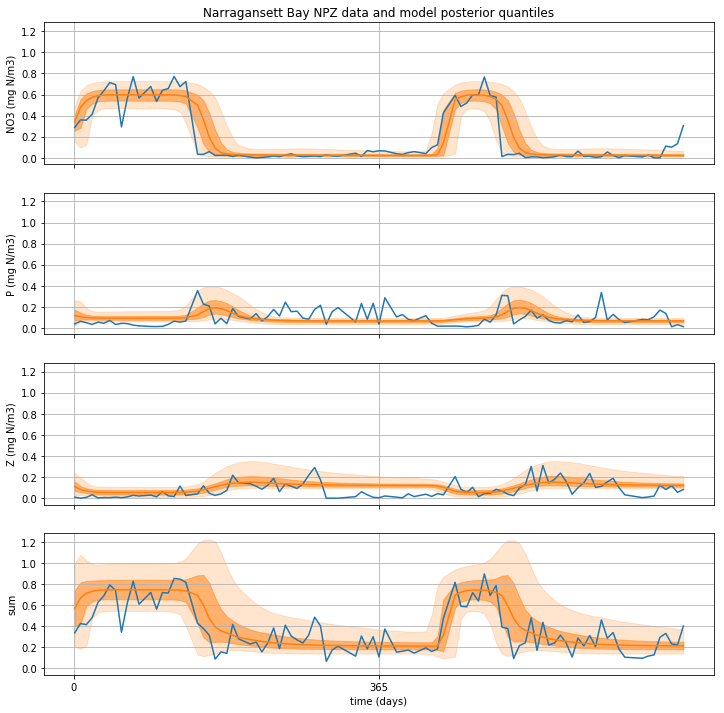

In [13]:
q = (5,25,50,75,95)
x_perc = np.percentile(mcmc['x'], q, axis=0)

fig, axs = plt.subplots(nrows=4, sharex=True, sharey=True, figsize=(12,12))
for iax,ax in enumerate(axs.flat[:-1]):
    ax.plot(t, data[index,iax+1])
    ax.fill_between(t, x_perc[0,:,iax], x_perc[-1,:,iax], alpha=0.2, color='C1')
    ax.fill_between(t, x_perc[1,:,iax], x_perc[-2,:,iax], alpha=0.5, color='C1')
    ax.plot(t, x_perc[2,:,iax], label='model', color='C1')
    ax.set_ylabel(data_names[iax+1])
    ax.grid(True)
axs[0].set_title('Narragansett Bay NPZ data and model posterior quantiles')
ax = axs[-1]
ax.plot(t,  np.sum(data[index,1:],axis=1))
ax.fill_between(t, np.sum(x_perc[0,:,:],axis=1), np.sum(x_perc[-1,:,:],axis=1), alpha=0.2, color='C1')
ax.fill_between(t, np.sum(x_perc[1,:,:],axis=1), np.sum(x_perc[-2,:,:],axis=1), alpha=0.5, color='C1')
ax.plot(t, np.sum(x_perc[2,:,:],axis=1), label='model', color='C1')
ax.set(xlabel=data_names[0], ylabel='sum', xticks=np.arange(0.0,nyears*365.0,365.0))
ax.grid(True)